# EDA | Exploring more questions
---
---

# Imports

#### Standard library imports

In [1]:
import sys
sys.path.append("../../")

#### Third party imports

In [2]:
import pandas as pd
import seaborn as sns

#### Local application imports

In [3]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# Extracting data

In [139]:
## Function parameters
db_crds = 'pc_db_prod'
sql_files_path = '../../pkg_dir/sql/'
sql_script = 'appointments.sql'
sql_params = sql_params_appointments

In [140]:
dfx = sql_to_df(db_crds, sql_files_path, sql_script, sql_params)

In [7]:
## inner join dfx with table containing phone numbers on patient id
sql_script_2 = 'appointments_with_phone.sql'
df_with_phone = sql_to_df(db_crds, sql_files_path, sql_script_2, sql_params)
df_with_phone.rename(columns={11: 'patient_id_phone_table', 12 : 'phone_number'}, inplace=True)

In [45]:
## version 2 of appointments.sql, oldest appointment is in 2018
sql_script_3 = 'appointments_v2.sql'
df_all = sql_to_df(db_crds, sql_files_path, sql_script_3, sql_params)

In [13]:
## selects all phone information from table
query = ''' 
SELECT pacientetelefono.pacienteid as patient_id,
pacientetelefono.pacientettipo as phone_type,
pacientetelefono.pacientettel as phone_number,
pacientetelefono.pacientetpref as preference
FROM pacientetelefono;
'''
df_only_phone = sql_string_to_df(db_crds, query)
df_only_phone.rename(columns = {0 : 'patient_id', 1 : 'phone_type', 2 : 'phone_number', 3: 'preference'}, inplace= True)

# Manipulating data

In [141]:
## Reference to simplify labels in appointment status
values_map = {
    
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    'CANCELA_PACIENTE' : 'no_show',
    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    
    
}

In [142]:
## Mapping values according to reference
dfx['appointment_status_simple'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

In [285]:
#dfx

In [39]:
## Mapping values according to reference
df_with_phone['appointment_status_simple'] = df_with_phone['appointment_status'].map(values_map).fillna(df_with_phone['appointment_status'])

In [284]:
#df_with_phone

In [50]:
## Mapping values according to reference
df_all['appointment_status_simple'] = df_all['appointment_status'].map(values_map).fillna(df_all['appointment_status'])

# Solving questions

###  With how much time in advance are the consultations scheduled? (overall and per specialty) (in 2023)

In [52]:
## function that computes the difference in days from the scheduled date to the consultation date for each specialty
def filter_by_speciality(specialty):
    df_specialty = dfx[dfx['medical_specialty'] == specialty]
    df_s = df_specialty.loc[:, ['appointment_id', 'medical_specialty', 'appointment_date', 'appointment_creation', 'appointment_status_simple']]
    df_s['appointment_date'] = pd.to_datetime(df_s['appointment_date'],  format='%Y-%m-%d').dt.date
    df_s['appointment_creation'] = pd.to_datetime(df_s['appointment_creation'], dayfirst=False, format='mixed').dt.date
    days_difference = df_s['appointment_date']-df_s['appointment_creation']
    df_s['days_until_consultation'] = [d.days for d in days_difference]
    return df_s

In [208]:
## dataframe of each specialty containing time in advance
'''
specialties = set(dfx['medical_specialty'])
for s in specialties:
    print(filter_by_speciality(s))
'''
specialties = set(dfx['medical_specialty'])
specialties

{'ALERGOLOGIA',
 'ANGIOLOGIA',
 'CARDIOLOGIA',
 'DERMATOLOGIA',
 'ENDOCRINOLOGIA',
 'GASTROENTEROLOGIA',
 'GERIATRIA',
 'GINECOLOGIA',
 'MEDICINA GENERAL+IA',
 'MEDICINA INTERNA',
 'NEFROLOGIA',
 'NEUMOLOGIA',
 'NEUROLOGIA',
 'NUTRICION',
 'OFTALMOLOGIA',
 'ONCOLOGIA',
 'ORTOPEDIA',
 'OTORRINOLARINGOLOGIA',
 'PEDIATRIA',
 'PROCTOLOGIA',
 'PSICOLOGIA',
 'REUMATOLOGIA',
 'ULTRASONIDO',
 'UROLOGIA',
 'Ultrasonido'}

In [58]:
## convert dates to datetime objects for differences
df_duc= dfx.loc[:, ['appointment_id', 'medical_specialty', 'appointment_date', 'appointment_creation', 'appointment_status_simple']]
df_duc['appointment_date'] = pd.to_datetime(df_duc['appointment_date'],  format='%Y-%m-%d').dt.date
df_duc['appointment_creation'] = pd.to_datetime(df_duc['appointment_creation'], dayfirst=False, format='mixed').dt.date

In [59]:
## compute difference, create new column 'days_until_consultation'
days_difference = df_duc['appointment_date']-df_duc['appointment_creation']
df_duc['days_until_consultation'] = [d.days for d in days_difference]
df_duc.sort_values(['medical_specialty', 'appointment_status_simple', 'days_until_consultation'])

,appointment_id,medical_specialty,appointment_date,appointment_creation,appointment_status_simple,days_until_consultation
77264,2023000742121,ALERGOLOGIA,2023-07-12,2023-12-07,completed,-148
77265,2023000742121,ALERGOLOGIA,2023-07-12,2023-12-07,completed,-148
52396,2023000742455,ALERGOLOGIA,2023-07-14,2023-12-07,completed,-146
52397,2023000742455,ALERGOLOGIA,2023-07-14,2023-12-07,completed,-146
96456,2023000742451,ALERGOLOGIA,2023-07-14,2023-11-07,completed,-116
...,...,...,...,...,...,...
113249,2023200600,Ultrasonido,2023-11-06,2023-03-11,no_show,240
45406,2023200593,Ultrasonido,2023-11-04,2023-02-11,no_show,266
13342,2022835662,Ultrasonido,2023-01-09,2022-04-11,no_show,273
20384,2022835655,Ultrasonido,2023-01-09,2022-04-11,no_show,273


In [61]:
#remove negative numbers
df_no_negative = df_duc.loc[df_duc['days_until_consultation'] >= 0]
df_no_negative

,appointment_id,medical_specialty,appointment_date,appointment_creation,appointment_status_simple,days_until_consultation
0,2022924396,CARDIOLOGIA,2023-08-01,2023-07-25,completed,7
1,2022924396,CARDIOLOGIA,2023-08-01,2023-07-25,completed,7
2,2023222975,OTORRINOLARINGOLOGIA,2023-07-29,2023-07-25,completed,4
3,2023000612663,GASTROENTEROLOGIA,2023-07-25,2023-07-22,completed,3
4,2023000612663,GASTROENTEROLOGIA,2023-07-25,2023-07-22,completed,3
...,...,...,...,...,...,...
228542,2023000823789,ORTOPEDIA,2023-07-21,2023-07-20,completed,1
228543,2023000823789,ORTOPEDIA,2023-07-21,2023-07-20,completed,1
228544,2023115669,GINECOLOGIA,2023-07-24,2023-07-21,completed,3
228545,2023000712934,ULTRASONIDO,2023-07-22,2023-07-22,completed,0


In [212]:
df_no_negative['days_until_consultation'].value_counts(normalize = True)

days_until_consultation
1      0.178487
0      0.116882
2      0.087168
3      0.062390
4      0.047374
         ...   
346    0.000005
229    0.000005
352    0.000005
387    0.000005
371    0.000005
Name: proportion, Length: 388, dtype: float64

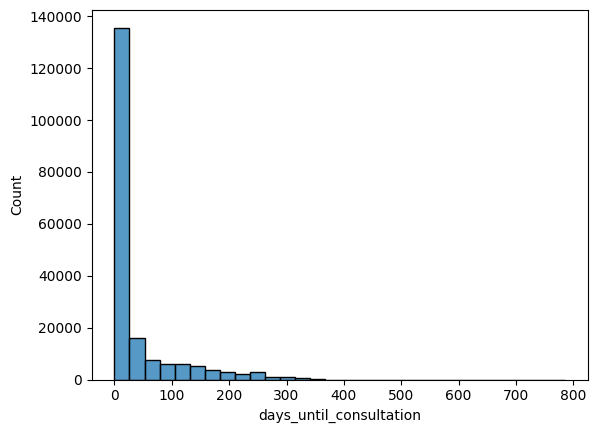

In [70]:
sns.histplot(df_no_negative['days_until_consultation'], bins=30, kde=False);

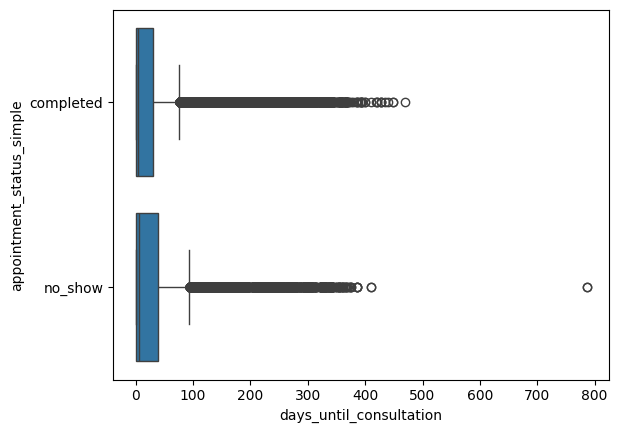

In [72]:
sns.boxplot(x='days_until_consultation', y='appointment_status_simple', data=df_no_negative);

### How many appointments datapoints do we have in the database?

In [76]:
df_all.sort_values(by = 'appointment_date')

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
58480,2023000670174,2020-05-24,19:30,20:00,24/05/2023 12:50:22,CONFIRMADO,DRA ROSY NAYELI CARMONA PICHARDO,GASTROENTEROLOGIA,COAPA,226497,1977-09-01,no_show
108652,2022792263,2020-07-22,11:00,11:30,18/04/2023 12:54:05,NO_CONFIRMADO,DRA BERTHA LUCIA PEREZ RIOS,DERMATOLOGIA,BASILICA,217707,2003-08-01,no_show
397595,2023001010340,2020-11-07,19:00,19:30,20/10/2023 15:05:20,NO_CONFIRMADO,DR. Norberto Rosas Flores,ULTRASONIDO,BASILICA,265980,1984-08-30,no_show
408546,2021000008,2021-02-15,11:30,12:00,15/02/2021 09:28:32,COMPLETADA,DRA SANDRA GEORGINA RUELAS GONZALEZ,DERMATOLOGIA,BASILICA,9,2004-06-19,completed
459704,2021000002,2021-02-15,08:30,09:00,15/02/2021 08:51:34,NO_PRESENTO,DRA SANDRA GEORGINA RUELAS GONZALEZ,DERMATOLOGIA,BASILICA,2,2005-10-04,no_show
...,...,...,...,...,...,...,...,...,...,...,...,...
86003,2023001478230,2023-12-31,12:30,13:00,30/12/2023 21:00:44,COMPLETADA,DRA DIANA GABRIELA RODALES TREJO,ORTOPEDIA,MONTEVIDEO,285175,1958-03-28,completed
236399,2023001478221,2023-12-31,08:00,08:30,29/12/2023 20:27:15,COMPLETADA,DRA DIANA GABRIELA RODALES TREJO,ORTOPEDIA,MONTEVIDEO,129735,1963-12-28,completed
186569,2023001424033,2023-12-31,09:00,09:30,22/12/2023 08:29:49,CONSULTA,DRA CRISTINA MAGDALENO HERNANDEZ,GINECOLOGIA,MARINA NACIONAL,259812,1991-03-25,completed
42328,2023001478226,2023-12-31,10:30,11:00,30/12/2023 11:34:34,COMPLETADA,DRA DIANA GABRIELA RODALES TREJO,ORTOPEDIA,MONTEVIDEO,285129,1979-06-05,completed


###  How many of the no-shows are patients that were confirmed?

In [90]:
dfx['appointment_status'].value_counts(normalize=True)

appointment_status
COMPLETADA            0.768988
NO_PRESENTO           0.124652
CONSULTA              0.059162
CONFIRMADO            0.019319
SALA_ESPERA           0.016220
MENSAJE_DEJADO        0.005869
NO_CONFIRMADO         0.002531
LLEGA_TARDE_ESPERA    0.002030
REAGENDAR             0.000770
CONFIRMADO_PAGO       0.000459
Name: proportion, dtype: float64

In [283]:
#confirmed patients that no-showed
dfx[dfx['appointment_status'] == 'CONFIRMADO'].shape[0]

3160

###  With how much time in advance are the appointments canceled?

#### Using df_all which includes data since 2020

In [218]:
df_cancelled = df_all.loc[df_all['appointment_status'] == 'CANCELA_PACIENTE']
df_cancelled

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
16,2021285959,2021-07-07,19:30,20:00,05/07/2021 15:20:57,CANCELA_PACIENTE,DR. JAVIER OSNAYA MARTINEZ,GASTROENTEROLOGIA,MARINA NACIONAL,56024,1982-05-03,no_show
17,2021451598,2021-09-02,11:30,12:00,26/08/2021 07:26:39,CANCELA_PACIENTE,DRA MARIA ARGENTINA DIAZ CASTRO,GASTROENTEROLOGIA,COAPA,107238,1978-07-06,no_show
30,2022475360,2022-06-13,19:30,20:00,12/06/2022 13:00:44,CANCELA_PACIENTE,DR. SAID CHAYA SALGADO,DERMATOLOGIA,MARINA NACIONAL,2425,2021-04-21,no_show
31,2022528850,2022-07-04,11:00,11:30,03/07/2022 14:35:21,CANCELA_PACIENTE,DRA JUANA GUADALUPE CABALLERO MARTINEZ,GINECOLOGIA,MARINA NACIONAL,2425,2021-04-21,no_show
32,2022323121,2022-09-08,13:00,13:30,07/07/2022 07:34:27,CANCELA_PACIENTE,DR. SAID CHAYA SALGADO,DERMATOLOGIA,MARINA NACIONAL,125398,1990-12-31,no_show
...,...,...,...,...,...,...,...,...,...,...,...,...
464227,2023231563,2023-07-11,18:30,19:00,05/07/2023 16:06:13,CANCELA_PACIENTE,DRA LITZAHAYA FLORES GARCIA,OTORRINOLARINGOLOGIA,MARINA NACIONAL,237099,2008-12-26,no_show
464228,2023000601424,2023-07-13,11:00,11:30,06/07/2023 11:10:26,CANCELA_PACIENTE,DR. KAREN YADHIRA SANCHEZ LASTRA,UROLOGIA,COAPA,111006,1939-07-31,no_show
464230,2023000756018,2023-07-18,11:40,12:20,06/07/2023 16:36:58,CANCELA_PACIENTE,DRA MONSERRAT PIEDRAS PONCE,NUTRICION,CUAJIMALPA,174565,1992-03-31,no_show
464249,2023000464587,2023-09-13,16:00,16:30,19/07/2023 17:20:56,CANCELA_PACIENTE,DR. Luis Carlos Siordia Solorio,ENDOCRINOLOGIA,BASILICA,239221,1939-04-25,no_show


In [221]:
df_cancelled.loc[:,'appointment_date'] = pd.to_datetime(df_cancelled['appointment_date'],  format='%Y-%m-%d').dt.date
df_cancelled.loc[:,'appointment_creation'] = pd.to_datetime(df_cancelled['appointment_creation'], dayfirst=False, format='mixed').dt.date
days_difference = df_cancelled['appointment_date']-df_cancelled['appointment_creation']
df_cancelled.loc[:,'days_until_consultation'] = [d.days for d in days_difference]
df_cancelled.sort_values(['medical_specialty', 'appointment_status_simple', 'days_until_consultation']).loc[df_cancelled['days_until_consultation'] >= 0]

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple,days_until_consultation
228469,2023001116403,2023-10-26,07:00,07:30,2023-10-26,CANCELA_PACIENTE,DR. EDGAR FLORES GONZAGA,ALERGOLOGIA,DEL VALLE,190646,2000-12-12,no_show,0
233980,2023001220136,2023-11-28,16:00,16:30,2023-11-28,CANCELA_PACIENTE,DR. EDGAR FLORES GONZAGA,ALERGOLOGIA,COAPA,277096,1990-08-10,no_show,0
249565,2023001116404,2023-10-26,07:30,08:00,2023-10-26,CANCELA_PACIENTE,DR. EDGAR FLORES GONZAGA,ALERGOLOGIA,DEL VALLE,190646,2000-12-12,no_show,0
270047,2023000742662,2023-11-10,12:30,13:00,2023-11-10,CANCELA_PACIENTE,DRA TANIA LISSET VEGA DIAZ,ALERGOLOGIA,TLALPAN,262648,2003-10-21,no_show,0
458413,2023001203517,2023-11-16,17:00,17:30,2023-11-16,CANCELA_PACIENTE,DR. EDGAR FLORES GONZAGA,ALERGOLOGIA,DEL VALLE,274010,1994-05-07,no_show,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73424,2023001148544,2023-11-01,17:30,18:00,2023-01-11,CANCELA_PACIENTE,DR. OMAR ANTONY GOMEZ MORALES,Ultrasonido,DEL VALLE,269744,1964-06-28,no_show,294
8336,2022785752,2022-12-05,09:30,10:00,2022-02-12,CANCELA_PACIENTE,DR. MATILDE ALMA ROSAS TORRES,Ultrasonido,TLALPAN,185625,1949-12-05,no_show,296
109446,2022785750,2022-12-05,08:30,09:00,2022-02-12,CANCELA_PACIENTE,DR. MATILDE ALMA ROSAS TORRES,Ultrasonido,TLALPAN,185625,1949-12-05,no_show,296
255322,2021732689,2021-11-05,15:30,16:00,2021-01-11,CANCELA_PACIENTE,DR. OMAR ANTONY GOMEZ MORALES,Ultrasonido,MARINA NACIONAL,115910,2000-11-29,no_show,298


### How many of the patients register a phone number?

#### On 2023 data

In [122]:
df_with_phone['phone_number'].value_counts(normalize = True)

phone_number
                        0.008948
5522695082              0.000188
5540046543              0.000175
5561036851              0.000175
5543387669              0.000171
                          ...   
5563163595              0.000004
5558476069              0.000004
5553009429              0.000004
5573592217              0.000004
5515960007              0.000004
Name: proportion, Length: 117362, dtype: float64

In [133]:
1-0.008948

0.991052

In [124]:
## 20 empty spaces indicate missing phone 
df_with_phone.loc[df_with_phone['phone_number'] == ' ' * 20]

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,patient_id_phone_table,phone_number,appointment_status_simple
145,2023000562896,2023-08-11,19:30,20:00,10/08/2023 09:05:04,COMPLETADA,DR. LORENA DEL PILAR QUINTAL MOGUEL,GINECOLOGIA,TLALPAN,17930,1981-09-17,17930,,completed
222,2023000868334,2023-08-09,17:00,17:30,07/08/2023 16:04:02,COMPLETADA,DR. VICENTE VAZQUEZ NARVAEZ,ORTOPEDIA,COAPA,7777,1962-06-06,7777,,completed
269,2023000786041,2023-08-17,10:30,11:00,16/08/2023 11:31:04,COMPLETADA,DR. MIGUEL ANGEL MONTERO MARQUEZ,OTORRINOLARINGOLOGIA,COAPA,21022,1964-08-01,21022,,completed
616,2023225699,2023-09-30,10:30,11:00,23/09/2023 09:28:06,NO_PRESENTO,DRA JUANA GUADALUPE CABALLERO MARTINEZ,GINECOLOGIA,MARINA NACIONAL,45860,1984-04-20,45860,,no_show
723,2022988478,2023-10-02,11:30,12:00,30/09/2023 10:53:13,COMPLETADA,DRA JUANA GUADALUPE CABALLERO MARTINEZ,GINECOLOGIA,MARINA NACIONAL,45860,1984-04-20,45860,,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227963,2023000329454,2023-02-21,16:00,16:30,17/02/2023 14:24:25,SALA_ESPERA,DR. Norberto Rosas Flores,ULTRASONIDO,BASILICA,101963,1992-07-21,101963,,completed
228008,2023000359306,2023-03-01,18:30,19:30,01/03/2023 15:02:12,COMPLETADA,DR. FELIX TARAZONA ALVARADO,ENDOCRINOLOGIA,COAPA,36224,1977-01-15,36224,,completed
228132,2023000360513,2023-04-14,17:00,17:30,24/03/2023 15:13:28,COMPLETADA,DR. FELIX TARAZONA ALVARADO,ENDOCRINOLOGIA,TLALPAN,11667,1994-06-07,11667,,completed
228135,2023165275,2023-07-14,12:00,12:30,14/04/2023 12:17:19,COMPLETADA,DRA ANDREA RODRIGUEZ ALVAREZ DE LA CUADRA,GINECOLOGIA,COAPA,37615,1984-12-19,37615,,completed


#### All known phone numbers in the database

In [77]:
df_only_phone.rename(columns = {0 : 'patient_id', 1 : 'phone_type', 2 : 'phone_number', 3: 'preference'}, inplace= True)

In [123]:
df_only_phone['phone_number'].value_counts(normalize = True)

phone_number
                        0.030900
5555555555              0.000377
0000000000              0.000134
5543454569              0.000104
4624001723              0.000069
                          ...   
5540091289              0.000003
3311533464              0.000003
5531444636              0.000003
5632938033              0.000003
5576526129              0.000003
Name: proportion, Length: 303948, dtype: float64

In [98]:
df_only_phone['phone_number'].isna().mean()

2.6728105672238585e-06

In [120]:
df_only_phone.loc[df_only_phone['phone_number'].isna()]

,patient_id,phone_type,phone_number,preference
170,26,A - CELULAR,None,S


In [121]:
## 20 empty spaces indicate missing phone 
df_only_phone.loc[df_only_phone['phone_number'] == ' ' * 20]

,patient_id,phone_type,phone_number,preference
11,70233,A - CELULAR,,S
58,70278,A - CELULAR,,S
86,10957,A - CELULAR,,S
90,11272,A - CELULAR,,S
92,11273,A - CELULAR,,S
...,...,...,...,...
372498,251425,A - CELULAR,,S
373753,252106,A - CELULAR,,N
373799,252366,A - CELULAR,,S
373887,252433,A - CELULAR,,S


### How does the no-show behavior vary by time of day? At what starting time do appointments most frequently result in no-shows?

In [156]:
df_no_shows = dfx.loc[dfx['appointment_status_simple'] == 'no_show']

In [157]:
df_no_shows['appointment_start_time'].value_counts(normalize = True)

appointment_start_time
12:00    0.048934
08:00    0.047910
10:00    0.047673
09:00    0.046688
11:00    0.044049
           ...   
17:20    0.000039
10:55    0.000039
13:45    0.000039
14:40    0.000039
16:40    0.000039
Name: proportion, Length: 94, dtype: float64

In [188]:
no_shows_by_time = df_no_shows.groupby('appointment_start_time')['appointment_start_time'].count()
no_shows_by_time = no_shows_by_time.reset_index(name='count')

In [203]:
no_shows_by_time.sort_values(by = 'count', ascending = False)

,appointment_start_time,count
34,12:00,1242
3,08:00,1216
17,10:00,1210
9,09:00,1185
26,11:00,1118
...,...,...
33,11:50,1
25,10:55,1
10,09:10,1
4,08:10,1


### How do no shows behave per week day?

In [266]:
## convert dates and extract day of week
df_no_shows.loc[:,'appointment_date'] = pd.to_datetime(df_no_shows['appointment_date'],  format='%Y-%m-%d')
df_no_shows.loc[:, 'day_number'] = [d.weekday() for d in df_no_shows['appointment_date']]

In [267]:
## apply mapping
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_no_shows.loc[:, 'day_of_week'] = df_no_shows['day_number'].map(day_mapping)


In [270]:
no_shows_by_day = df_no_shows.groupby('day_of_week')['day_of_week'].count()
no_shows_by_day = no_shows_by_day.reset_index(name='count')

In [275]:
## helps with formatting chronologically
nvert_day_mapping = {v: k for k, v in day_mapping.items()}
no_shows_by_day['day_number'] = no_shows_by_day['day_of_week'].map(invert_day_mapping)

In [279]:
no_shows_by_day.sort_values(by = 'day_number', inplace = True)
no_shows_by_day

,day_of_week,count,day_number
1,Monday,4725,0
5,Tuesday,4651,1
6,Wednesday,4362,2
4,Thursday,4299,3
0,Friday,4408,4
2,Saturday,2574,5
3,Sunday,362,6


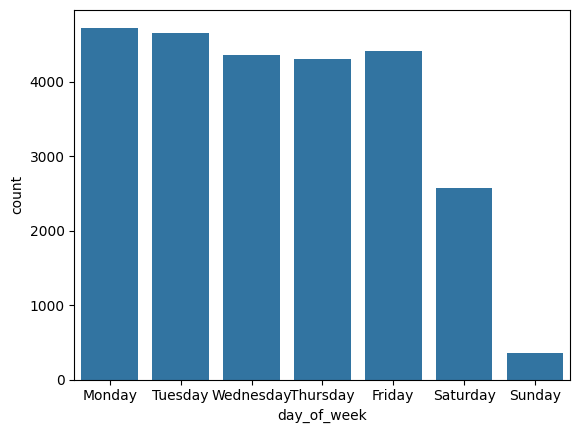

In [278]:
sns.barplot(
    no_shows_by_day, 
    x="day_of_week", 
    y="count"
);

# Notes

### Duplicated values

In [23]:
dfx.loc[dfx[['appointment_id']].duplicated(keep=False), :].sort_values('appointment_id')

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
90473,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
90444,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
2650,2023000300922,2023-07-31,19:30,20:00,27/07/2023 10:16:46,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
2688,2023000300922,2023-07-31,19:30,20:00,30/07/2023 09:02:21,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
31990,2023000300993,2023-09-18,16:30,17:00,16/09/2023 13:16:36,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,255714,1997-06-27,completed
...,...,...,...,...,...,...,...,...,...,...,...,...
101690,2023138378,2023-12-22,08:30,09:00,19/12/2023 13:50:48,COMPLETADA,DR. Hector Javier Sotelo Reyna,NEUMOLOGIA,BASILICA,282656,1990-03-08,completed
95790,2023144492,2023-12-22,12:00,12:30,17/12/2023 15:27:12,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
95810,2023144492,2023-12-22,12:00,12:30,21/12/2023 11:58:45,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
163421,2023144498,2023-12-22,11:00,11:30,19/12/2023 18:14:49,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,282769,1967-11-18,completed


---

---